# Nanodegree Machine Learning Engineer
## Capstone Project
## Predicting Rains in Australia

Traditionally, weather forecasting has been done through physical simulations of the atmosphere. Its current state is sampled, and the future state is calculated from fluid dynamics and thermodynamics equations. However, this physical model is unstable under disturbances and uncertainties in the measurements, in addition to not fully understanding the complex atmospheric processes. Thus, machine learning represents a viable alternative in the weather forecast, since it is relatively robust to disturbances and does not require a complete understanding of physical processes ([Holmstromet al., 2016](http://www.ep.liu.se/ecp/153/024/ecp18153024.pdf)).

On the other hand, the use of machine learning still presents some resistance for this purpose. In the case of deep learning algorithms, it is not always possible to understand how a certain result has been achieved. That way, it becomes difficult to rely on "black boxes" for predicting emergency situations, such as floods ([Nature, 2017](https://go.nature.com/2E1WYVr)).

Based on the proposed by Joe Young on [kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package), the objective is to predict whether there will be rain on a day, given the previous day weather conditions. The database relies on various weather stations measurements in Australia between 31st October 2007 and 24th June 2017.

----
## 1) Exploratory Data Analysis
### 1.1) Importing Libraries and Inserting new columns

Two columns were added to the original dataset: `'Month'` and `'Season'`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from time import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

data = pd.read_csv("weatherAUS.csv")
data.insert(loc=1, column='Month', value = data['Date'].apply(lambda x: x[5:7])) #create column "Month"
data.insert(loc=2, column='Day', value = data['Date'].apply(lambda x: x[5:10])) #create column "Month"
data.insert(loc=3, column='Season', value = data['Month'].replace(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], ['summer','summer', 'summer', 'fall', 'fall', 'fall', 'winter', 'winter', 'winter', 'spring', 'spring', 'spring'])) #create column "Season"
data['RainTomorrow'] = data['RainTomorrow'].replace(['Yes', 'No'], [1,0])
print('Dataset shape:',data.shape)
display(data.head(n=5))

Dataset shape: (142193, 27)


,Date,Month,Day,Season,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,12,12-01,spring,Albury,13.4,22.9,0.6,NaN,NaN,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,0
1,2008-12-02,12,12-02,spring,Albury,7.4,25.1,0.0,NaN,NaN,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,0
2,2008-12-03,12,12-03,spring,Albury,12.9,25.7,0.0,NaN,NaN,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,0
3,2008-12-04,12,12-04,spring,Albury,9.2,28.0,0.0,NaN,NaN,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,0
4,2008-12-05,12,12-05,spring,Albury,17.5,32.3,1.0,NaN,NaN,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,0


### 1.2) Variable Fill

The variables `Sunshine`, `Evaporation`, `Cloud3pm`, and `Cloud9am` presented a low fill, less than 65%.

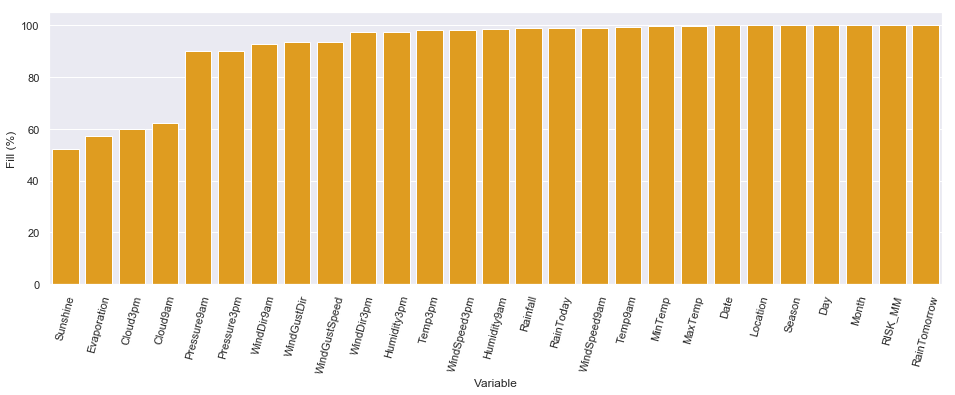

In [2]:
fill = pd.DataFrame(100*data.count().sort_values()/data.shape[0])
fill.reset_index(level=0, inplace=True)
fill.columns = ['Variable','Fill (%)']

sns.set()
plt.figure(figsize=(16, 5))
g = sns.barplot(x = 'Variable', y = 'Fill (%)', data = fill,color = 'orange')
g = plt.xticks(rotation=75)

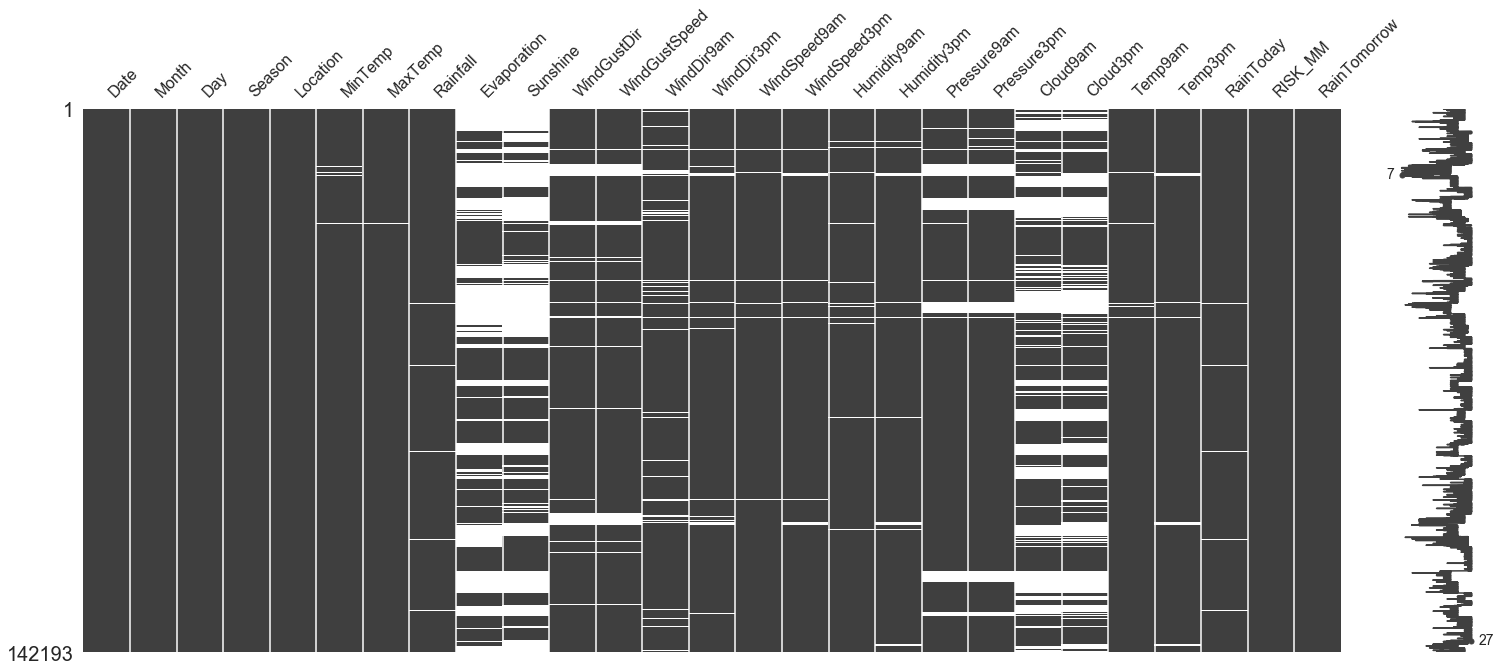

In [3]:
import missingno as msno
msno.matrix(data)

### 1.3) Variable Types



**Numerical variables:** `MinTemp`, `MaxTemp`, `Rainfall`, `Evaporation`, `Sunshine`, `WindGustSpeed`, `WindSpeed9am`, `WindSpeed3pm`, `Humidity9am`, `Humidity3pm`, `Pressure9am`, `Pressure3pm`, `Cloud9am`, `Cloud3pm`, `Temp9am`, `Temp3pm`, `RISK_MM`


**Categorical variables:** `Date`, `Month`, `Season`, `Location`, `WindGustDir`, `WindDir9am`, `WindDir3pm`, `RainToday`, `RainTomorrow`

In [4]:
types = pd.DataFrame(data.dtypes)
types.reset_index(level=0, inplace=True)
types.columns = ['Variable','Type']

numerical_variables = list(types[types['Type'] == 'float64']['Variable'].values)
categorical_variables = list(types[types['Type'] == 'object']['Variable'].values)

print ('numerical_variables:', numerical_variables) 
print ('\ncategorical_variables:', categorical_variables) 

numerical_variables: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM']

categorical_variables: ['Date', 'Month', 'Day', 'Season', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


### 1.4) Variable Correlations

- `Pressure9am` and `Pressure3pm` have very strong correlation, almost next to 1.

- `MinTemp`, `MaxTemp`, `Temp9am`, `Temp3pm` have strong correlation between them.

- `WindGustSpeed`, `WindSpeed9am`, `WindSpeed3pm` have moderate correlation between them.

- `Humidity9am`, `Humidity3pm` have moderate correlation between them.

- `Cloud9am`, `Cloud3pm` have moderate correlation between them.

Having some variables  with correlation between them is a signal that it will be interesting to perform Feature Selection or Dimensionality Reduction.

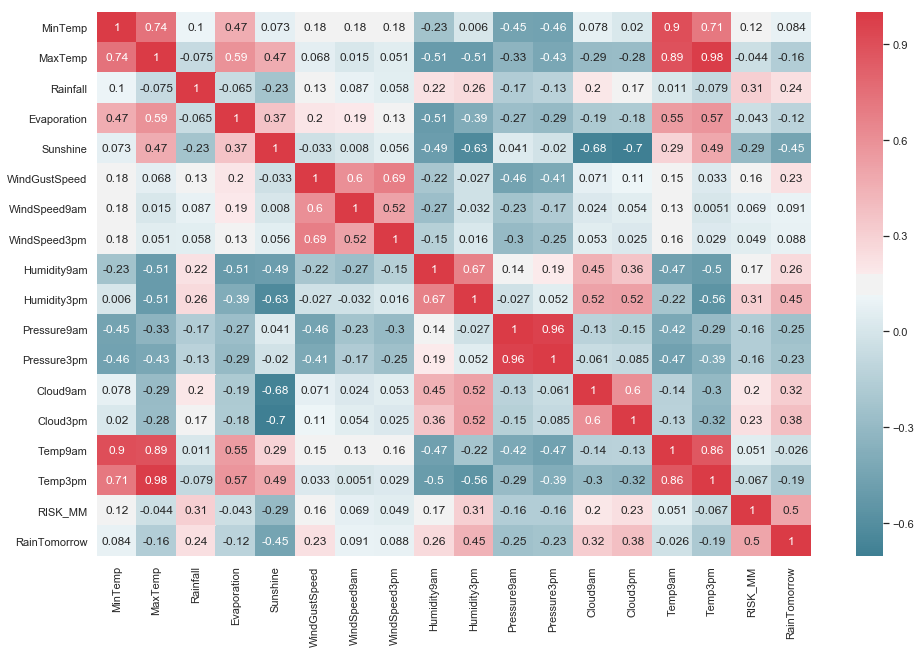

In [5]:
#pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
f, ax = plt.subplots(figsize=(16, 10))
corr = data.corr()
corr_mtx = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=False, ax=ax, annot = True)

### 1.5) Influence of the predictor variables on target variable

#### Numerical variables

Below, the distributions of each variable are plotted for when there is rain or not. If the distributions are similar, it is a sign that they do not influence the occurrence of rains the next day.

For example, `Sunshine` today when it is going to rain tomorrow is considerably different from when it is not going to rain tomorrow.

On the other hand, there is not such a considerable difference between `MinTemp` distributions.

This information is useful to identify the variables that are going to be used to predict wheter it will rain tomorrow.

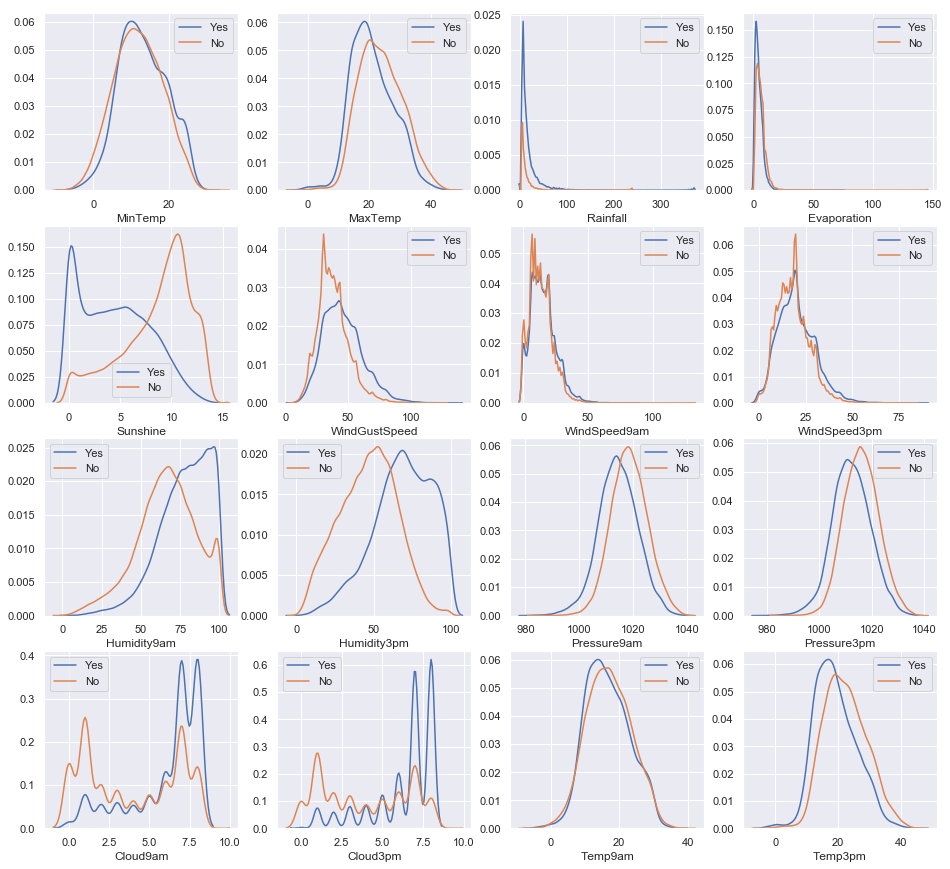

In [6]:
n_row = 4
n_col = 4
list_of_variables = numerical_variables[0:-1]
f, axes = plt.subplots(n_row, n_col, figsize=(16, 15))
total = n_row*n_col
k = 0
for i in range(n_row):
    for j in range(n_col):
        sns.distplot(data[data['RainTomorrow']==1][list_of_variables[k]].dropna(),hist = False, kde = True, label = 'Yes',ax=axes[i, j])#.set_title(list_of_variables[k])
        sns.distplot(data[data['RainTomorrow']==0][list_of_variables[k]].dropna(), hist = False, kde = True, label = 'No',ax=axes[i, j])#.set_title(list_of_variables[k])
        k = k + 1

#### Categorical variables

Below, the probabilities of rain tomorrow for the classes of each categorical variables are plotted.

Regarding all the dataset, the probability of rain tomorrow is **22%**. This way, classes whose probabilities deviate from that number tend to influence prediction more

For example, regarding `RainToday`, the probability of rain tomorrow when it rains today is three times the probability when it does not rain today.

In [7]:
print('Probability of Rain Tomorrow:',np.mean(data['RainTomorrow']))

Probability of Rain Tomorrow: 0.22418121848473554


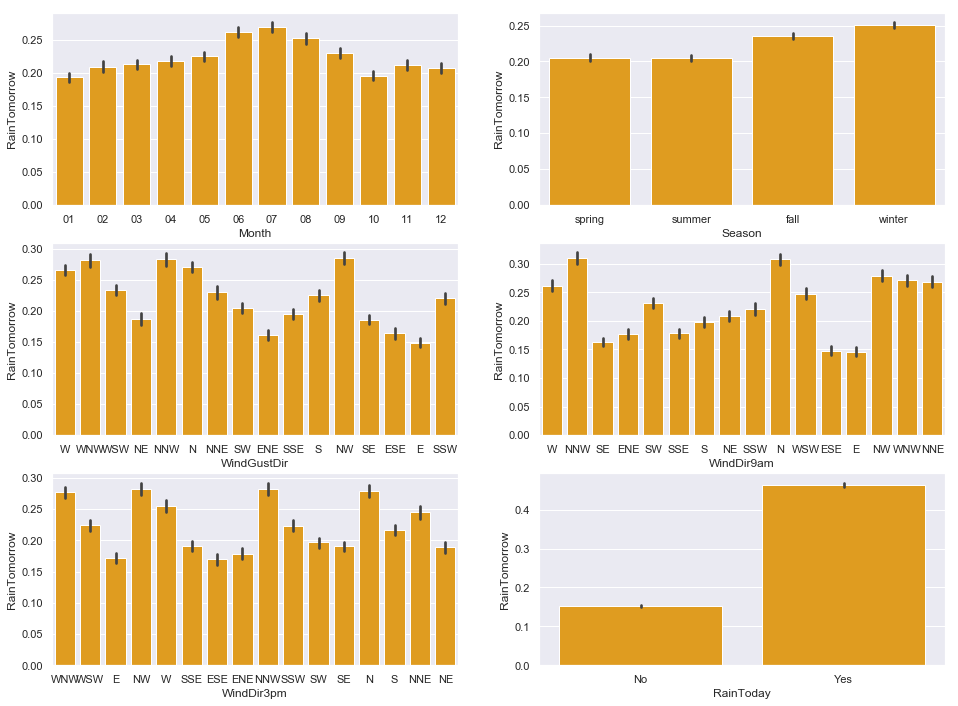

In [8]:
from numpy import mean

n_row = 3
n_col = 2
list_of_variables = ['Month', 'Season', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
f, axes = plt.subplots(n_row, n_col, figsize=(16, 12))
k = 0
for i in list(range(n_row)):
    for j in list(range(n_col)):
        sns.barplot(x = list_of_variables[k], y = 'RainTomorrow', data = data, estimator = mean, color = 'orange', ax=axes[i, j])
        #g.xticks(rotation=45)
        k = k + 1

----
## 2) Data Preprocessing
### 2.1) Dropping variables


The variables `Sunshine`, `Evaporation`, `Cloud3pm`, `Cloud9am` were removed because they had a low fill percentage

`Location` was removed, since we want forecast rain regardless the location.

`Date`, `Month`, `Day` and were removed, because `Season` is going to be used instead.

`RISK_MM` was removed to avoid data leakage.

In [9]:
data_final_variables = data.drop(columns=['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','Date', 'Month', 'Day', 'RISK_MM'],axis=1)

data_final_variables = data_final_variables.dropna()

features_raw = data_final_variables.drop(columns = ['RainTomorrow'])
income_raw = data_final_variables['RainTomorrow']

### 2.2) Feature Scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures

scaler = MinMaxScaler()

types_aux = pd.DataFrame(features_raw.dtypes)
types_aux.reset_index(level=0, inplace=True)
types_aux.columns = ['Variable','Type']
numerical = list(types_aux[types_aux['Type'] == 'float64']['Variable'].values)

features_minmax_transform = pd.DataFrame(data = features_raw)
features_minmax_transform[numerical] = scaler.fit_transform(features_raw[numerical])

features_minmax_transform['RainToday'] = features_minmax_transform['RainToday'].replace(['Yes', 'No'], [1,0])

features_minmax_transform.head()

,Season,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday
0,spring,0.513064,0.446154,0.001632,W,0.289062,W,WNW,0.211765,0.258824,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0
1,spring,0.370546,0.494505,0.000000,WNW,0.289062,NNW,WSW,0.023529,0.235294,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0
2,spring,0.501188,0.507692,0.000000,WSW,0.304688,W,WSW,0.200000,0.282353,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0
3,spring,0.413302,0.558242,0.000000,NE,0.132812,SE,E,0.105882,0.082353,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0
4,spring,0.610451,0.652747,0.002720,W,0.265625,ENE,NW,0.058824,0.211765,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0


### 2.3) One-hot encoding

In [11]:
features_final = pd.get_dummies(features_minmax_transform)

encoded = list(features_final.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

# Descomente a linha abaixo para ver as colunas após o encode
print (encoded)

65 total features after one-hot encoding.
['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'Season_fall', 'Season_spring', 'Season_summer', 'Season_winter', 'WindGustDir_E', 'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_E', 'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE', 'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDi

----
## 3) Model Training
### 3.1) Evaluating Metrics


**Accuracy** and **F-beta score** with **K-Fold Cross Validation** (k = 5) were adopted to evaluate the models.

The stategy is to test some classifiers, choose models with good performance and reasonable time training. Next, I workd to improve them. 

The following models were tested:

- MultinomialNB
- Decision Tree
- Random Forest
- Logistic Regression
- SGD

Logistic Regression presented the best **Accuracy** and **F1-Score** with a reasonable time training.


In [12]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

X = features_final
y = income_raw

clf_a = MultinomialNB()
clf_b = DecisionTreeClassifier(random_state = 0)
clf_c = RandomForestClassifier(random_state = 0)
clf_d = LogisticRegression(random_state = 0)
clf_e = SGDClassifier(random_state = 0)

list_clf = [clf_a, clf_b, clf_c, clf_d, clf_e]

results = []
for clf in list_clf:
    start = time()
    clf_name = clf.__class__.__name__
    scores_f1 = cross_val_score(clf, X, y, cv=5, scoring = 'f1')
    scores_ = cross_val_score(clf, X, y, cv=5)
    end = time()
    train_time = end  - start
    results.append([clf_name, np.mean(scores_f1), np.mean(scores_), train_time])

df_results = pd.DataFrame(np.array(results))
df_results.columns = ['Classifier', 'F1-Score', 'Accuracy', 'Train Time']
df_results.sort_values(by=['F1-Score'], ascending=False)

,Classifier,F1-Score,Accuracy,Train Time
3,LogisticRegression,0.5940335163203853,0.8473855820790653,13.395174264907837
4,SGDClassifier,0.5773492849907051,0.8450211319143646,2.4534358978271484
2,RandomForestClassifier,0.5473752642901741,0.8381846952921519,17.358571529388428
1,DecisionTreeClassifier,0.5076012624351657,0.7742396032510251,16.53268837928772
0,MultinomialNB,0.27188015317647685,0.7794733653261,0.8491165637969971


### 3.2) Dimensionality Reduction


As there are some variables that are highly correlated with each other, performing PCA could bring some improvements to the prediction.

The results show that the dimensionality reduction did not bring significant gains in the computational time that justified the loss of prediction capacity.

In [13]:
from sklearn.decomposition import PCA

clf_pca = LogisticRegression(random_state=0)

list_n = [10,20,30,40,50]

results_pca = []
for i in list_n:
    start = time()
    pca = PCA(n_components = i)
    pca.fit(X)
    X_pca = pca.fit_transform(X)
    scores_f1 = cross_val_score(clf_pca, X_pca, y, cv=5, scoring = 'f1')
    scores_ = cross_val_score(clf_pca, X_pca, y, cv=5)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    end = time()
    train_time = end  - start
    results_pca.append([i, explained_variance, np.mean(scores_f1), np.mean(scores_), train_time])

df_results_pca = pd.DataFrame(np.array(results_pca))
df_results_pca.columns = ['Number of components', 'Cumulative Explained Variance Ration','F1-Score', 'Accuracy', 'Train Time']
df_results_pca.sort_values(by=['F1-Score'], ascending=False)

,Number of components,Cumulative Explained Variance Ration,F1-Score,Accuracy,Train Time
4,50.0,0.982446,0.561895,0.836644,12.237977
3,40.0,0.892566,0.385968,0.800301,9.031537
2,30.0,0.758182,0.380988,0.798849,7.527962
1,20.0,0.602477,0.349697,0.790259,5.828617
0,10.0,0.422803,0.339859,0.790383,3.720013


### 3.3) Feature Selection


Unlike PCA, training the model with only best featuers brought significant gains in the computational time, without a significant loss in prediction capacity.

Adopting the 10 most relevant features, the accuracy loss was 0.3% and F1-Score was 2%, while it performed 66% faster.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf_feature_importance = DecisionTreeClassifier(random_state=0)
model_feature_importance = clf_feature_importance.fit(X_train,y_train)
importances = model_feature_importance.feature_importances_

df_feature_importance = pd.DataFrame()
df_feature_importance['features'] = X.columns
df_feature_importance['importances'] = importances
df_feature_importance = df_feature_importance.sort_values(by=['importances'], ascending=False)
features = list(df_feature_importance['features'].values)

list_n_features = [10,20,30,40,50,60]

results_features = []
for i in list_n_features:
    start = time()
    X_selected_features = X[features[0:i]]
    scores_f1 = cross_val_score(LogisticRegression(random_state=0), X_selected_features, y, cv=5, scoring = 'f1')
    scores_ = cross_val_score(LogisticRegression(random_state=0), X_selected_features, y, cv=5)
    cummulative_importance = sum(df_feature_importance.importances[0:i])
    end = time()
    train_time = end  - start
    results_features.append([i, cummulative_importance, np.mean(scores_f1), np.mean(scores_), train_time])

df_results_features = pd.DataFrame(np.array(results_features))
df_results_features.columns = ['Number of features', 'Cumulative Importance','F1-Score', 'Accuracy', 'Train Time']
df_results_features.sort_values(by=['F1-Score'], ascending=False)

,Number of features,Cumulative Importance,F1-Score,Accuracy,Train Time
4,50.0,0.962243,0.589839,0.846978,11.773509
5,60.0,0.990286,0.589510,0.846775,12.391890
3,40.0,0.931406,0.588666,0.846482,11.429378
1,20.0,0.859922,0.588185,0.846961,9.228141
2,30.0,0.897634,0.587795,0.846429,10.189863
0,10.0,0.754302,0.577574,0.844091,4.443905


In [15]:
print ('Most important features:\n')
for i in features[0:10]:
    print(i)

Most important features:

Humidity3pm
Pressure3pm
WindGustSpeed
Pressure9am
MinTemp
Humidity9am
Temp9am
Temp3pm
MaxTemp
Rainfall


### 3.4) Parameters Tuning

Cross-Validated Grid-Search was adopted to tune the hyperparameters of Logistic Regression.

The tuning brought insignificant improvement to the model.

In [25]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf_grid = LogisticRegression(random_state=0, n_jobs = -1)

parameters = {'C':np.logspace(0, 4, 10),
             'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(clf_grid, parameters, scoring=scorer, n_jobs = -1)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

print ("Logistic Regression\n")
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(np.mean(cross_val_score(clf_grid, X, y, cv=5))))
print ("F-score on testing data: {:.4f}".format(np.mean(cross_val_score(clf_grid, X, y, cv=5, scoring = 'f1'))))
print ("\nOptimized Model\n------")
print ("Accuracy score on testing data: {:.4f}".format(np.mean(cross_val_score(best_clf, X, y, cv=5))))
print ("F-score on testing data: {:.4f}".format(np.mean(cross_val_score(best_clf, X, y, cv=5, scoring = 'f1'))))
print ('\n')
print (best_clf)

Logistic Regression

Unoptimized model
------
Accuracy score on testing data: 0.8474
F-score on testing data: 0.5940

Optimized Model
------
Accuracy score on testing data: 0.8474
F-score on testing data: 0.5949


LogisticRegression(C=7.742636826811269, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


### 4) Conclusion


Finally, the model performance is described below.


\begin{align}
Accuracy & = 84.7\%
\\
F_{1}-Score & = 59.5\%
\end{align}

Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix

final_model = LogisticRegression()
final_model.fit(X_train,y_train)
y_pred = final_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[16700,   950],
       [ 2469,  2466]], dtype=int64)